In [301]:
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from skimage import data
from skimage import io
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd

## IncuCyte TMRE assay
This program will take raw TIFF files from IncuCyte fluorescence microscopy and assign TMRE fluorescence normalized to NAO fluorescence. TMRE intensity is controlled by the mitochondrial membrane potential while NAO is a membrane potential independent mitochondrial stain. The program uses the NAO channel to filter pixels containing mitochondria, then applies this filter to the TMRE channel.

It works by the following steps:
1. Find minimum NAO intensity percentile using 100 - confluency/3
2. Filter between minimum NAO intensity percentile and the maximum 99 percentile.
3. Filter TMRE channel between 0 and 99 percentile.
4. Apply both filters to TMRE/NAO channels.
5. For all none filtered pixels, divide the TMRE intensity with the NAO intensity, then take the average. This is the normalized TMRE value reported.


##  How to use
Step-wise guide on how to use:
1. Treat cells with drug either acutely or with time for adaptation e.g. 24 h. Cells should be 30-80% confluent after treatment.
2. Add 0.5-20 nM TMRE (non-quencing concentration has to be determined emperically) and 20 nM NAO, mix and move plates to IncuCyte.
3. After 30-60 min incubation start imaging each well with 4 or 9 fields of view per well. Do not use more fields per view to minimize the time from first to last well, to avoid signal drift. Use the "Adeherent Cell-by-Cell" option with 20x resolution and image phase, GFP and RFP channels using default values. Images can be gathered with a cycle time of 1-2 h. 2-4 cycles are enough.
4. To download the raw image files pres the "Export Images and Movies" button on the lower left side of the image tab, then choose "As Stored" and export Green and Red channels as uncalibrated. Choose a file name prefix that indicates the drug/plate/replicate but do not use underscore in the prefix, otherwise use the default settings.
6. Download all TIFF images and put into a folder structure on a per plate basis with subfolders for GFP and RFP channels e.g. (RFP and GFP must be capitalized):

   --> plate1
         --> GFP
         --> RFP
   --> plate2
         --> GFP
         --> RFP  

7. Set input parameters i.e. name of the plate folders, plate dimensions and approximate confluency (minimum 10%).
8. Run the functions to read and assign TMRE.
9. Check percentiles are correct by visual inspection using plotting.

## Set input parameters

In [304]:
plate_folders = ['BAM15-Rep1', 'BAM15-Rep2', 'BAM15-Rep3.1']
conf_est = 50 # Minimum confluency is 10%
assert(conf_est >= 10)
plate_dim = (3, 4) # Number of rows, columns on plate

## Main program

In [305]:
# Utility dictionaries:
percentile_dict = {'GFP': {'min': 100 - conf_est/10, 'max': 98},
                   'RFP': {'min': 0, 'max': 98}}
abc2int = {a:n for a, n in zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], [0, 1, 2, 3, 4, 5, 6, 7])}

In [306]:
def read_images(plate_folders):
    '''
    Read the images in the folder structure into a dictionary
    that pairs each field of view image with its corresponding well.
    '''
    # Dict to hold all image information, structure:
    # image_dict[plate][well][time]['[GR]FP'][path_list] = list(paths)
    # image_dict[plate][well][time]['[GR]FP'][imat] = combined image (matrix format)
    # image_dict[plate][well][time]['[TMRE_norm] = RFP/GFP (normalized TMRE signal)
    image_dict = dict()

    for plate in plate_folders:
        # Glob to find all TIFF files:
        data_path = Path(plate)
        gfp_files = list(data_path.glob('GFP/*.tif'))
        rfp_files = list(data_path.glob('RFP/*.tif'))

        image_dict[plate] = dict()
        # Read all GFP (NAO) channel images:
        for p in natsorted(gfp_files):
            cols = str(p).split('_')
            assert(cols[1][0] in abc2int and cols[1][1] in '0123456789') # assert this column contains the well ID
            if cols[1] not in image_dict[plate]:
                image_dict[plate][cols[1]] = dict()
            if cols[3] not in image_dict[plate][cols[1]]:
                # New well entry, to hold all image information:
                image_dict[plate][cols[1]][cols[3]] = {'TMRE_norm': None, 'GFP': {'path_list': [], 'imat': None}, 'RFP': {'path_list': [], 'imat': None}}
            # Store each field of view belonging to the well:
            image_dict[plate][cols[1]][cols[3]]['GFP']['path_list'].append(p)

        # Read the RFP (TMRE) images:
        for p in natsorted(rfp_files):
            cols = str(p).split('_')
            assert(cols[1][0] in abc2int and cols[1][1] in '0123456789') # assert this column contains the well ID
            image_dict[plate][cols[1]][cols[3]]['RFP']['path_list'].append(p)
    return(image_dict)

In [307]:
def combine_image(image_list):
    '''
    Combines a list of images that are different field of views
    from the same well.
    '''
    Ndim = int(len(image_list)**0.5)
    image_cols = []
    image_idx = 0
    for i in range(0, Ndim):
        image_row = [image_list[j] for j in range(image_idx, image_idx+Ndim)]
        image_idx += Ndim
        row_cat = np.concatenate(image_row, axis=1)
        image_cols.append(row_cat)
    return(np.concatenate(image_cols, axis=0))

In [308]:
def filter_images(image_dict, percentile_dict):
    '''
    Combine all the fields of view per well into one image.
    Then apply filters and calculate the normalizated TMRE.
    '''
    # Dataframe to store the normalizated TMRE values:
    TMRE_df = pd.DataFrame(columns=['Plate', 'Well', 'Time', 'TMRE_norm'])
    row_idx = 0

    for plate in image_dict:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                master_mask = None
                for fl in ['GFP', 'RFP']: # first handle GFP channel
                    # Collect and merge all the fields of view per well into one image:
                    image_list = list()
                    for filename in image_dict[plate][well][time][fl]['path_list']:
                        image_list.append(io.imread(filename))
                    image_dict[plate][well][time][fl]['imat'] = combine_image(image_list)
                    # Find the percentile cutoff values:
                    fl_min = np.percentile(image_dict[plate][well][time][fl]['imat'], percentile_dict[fl]['min'])
                    fl_max = np.percentile(image_dict[plate][well][time][fl]['imat'], percentile_dict[fl]['max'])
                    # Find all pixels that are not within the percentile cutoff:
                    mask = (image_dict[plate][well][time][fl]['imat'] < fl_min) | (image_dict[plate][well][time][fl]['imat'] > fl_max)
                    # Update master mask:
                    if master_mask is None:
                        master_mask = mask
                    else:
                        master_mask = master_mask | mask
                # Filter both channels based on the master mask:
                for fl in ['GFP', 'RFP']:
                    image_dict[plate][well][time][fl]['imat'][master_mask] = 0
                # Calculate the normalized TMRE, per pixel and average,
                # note, master_mask is reversed:
                image_dict[plate][well][time]['TMRE_norm'] = np.average(image_dict[plate][well][time]['RFP']['imat'][~master_mask] / image_dict[plate][well][time]['GFP']['imat'][~master_mask])
                # image_dict[plate][well][time]['TMRE_norm'] = np.average(image_dict[plate][well][time]['RFP']['imat'][~master_mask])
                TMRE_df.loc[row_idx] = [plate, well, time[:-4], image_dict[plate][well][time]['TMRE_norm']]
                row_idx += 1

    return(image_dict, TMRE_df)

In [309]:
def plot_plate(plate_imat, fl, image_name, image_shape, plate_dim):
    '''
    Plot one plate with formatting.
    '''
    # The merged field of view is not perfectly square,
    # so sizing has to be adjusted:
    fig = plt.figure(figsize=(plate_dim[1]*3, (image_shape[0] / image_shape[1])*plate_dim[0]*3))
    gs = GridSpec(*plate_dim, figure=fig, hspace=0.05)
    # Choosing generic green/red color gradients for GFP/RFP channels: 
    if fl == 'GFP':
        color = 'Greens'
    elif fl == 'RFP':
        color = 'Reds'
    for i in range(plate_dim[0]):
        for j in range(plate_dim[1]):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(plate_imat[i][j], color)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.set_aspect('equal')
    fig.suptitle('{}'.format(image_name))
    fig.subplots_adjust(wspace=0, hspace=0)
    return(fig)

In [314]:
def plot_all(image_dict, plate_dim):
    '''
    Plot the merged and filtered images
    in the shape of the well.
    '''
    plate = list(image_dict.keys())[0]
    well = list(image_dict[plate].keys())[0]
    time = list(image_dict[plate][well].keys())[0]
    time_list = image_dict[plate][well].keys()
    fl_list = ['GFP', 'RFP']
    image_shape = image_dict[plate][well][time]['GFP']['imat'].shape

    fig_list = list()
    for plate in image_dict:
        for time in natsorted(time_list):
            if time not in image_dict[plate][well]:
                continue
            for fl in fl_list:
                # Placeholder matrix to hold the "imat" matrices of
                # the merged image from each well:
                plate_imat = [[None for j in range(plate_dim[1])] for i in range(plate_dim[0])]
                # Fill the "plate_imat":
                for well in image_dict[plate]:
                    i = abc2int[well[0]]
                    j = int(well[1:]) - 1
                    plate_imat[i][j] = image_dict[plate][well][time][fl]['imat']

                # Plot one plate:
                image_name = '{} {} {}'.format(plate, fl, time)
                fig = plot_plate(plate_imat, fl, image_name, image_shape, plate_dim)
                fig_list.append(fig)
    return(fig_list)

In [311]:
# Read images into dict:
image_dict = read_images(plate_folders)

In [312]:
# Filter and calculate normalized TMRE:
image_dict, TMRE_df = filter_images(image_dict, percentile_dict)

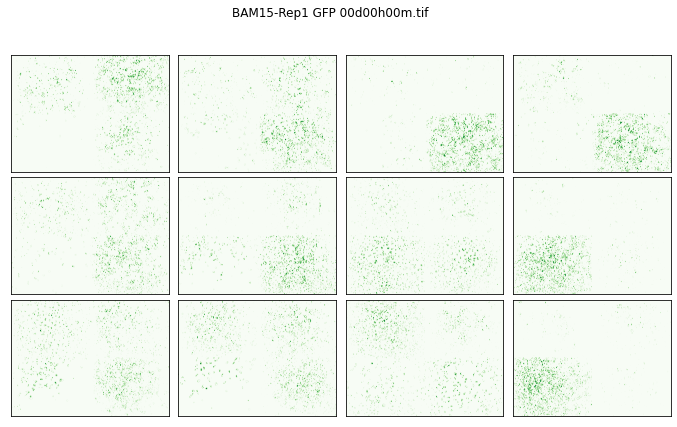

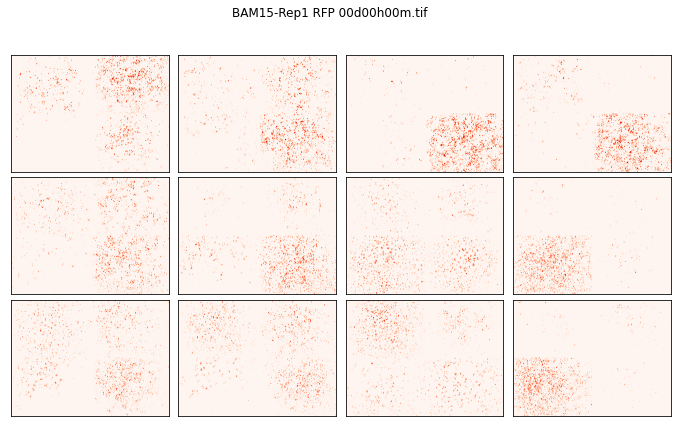

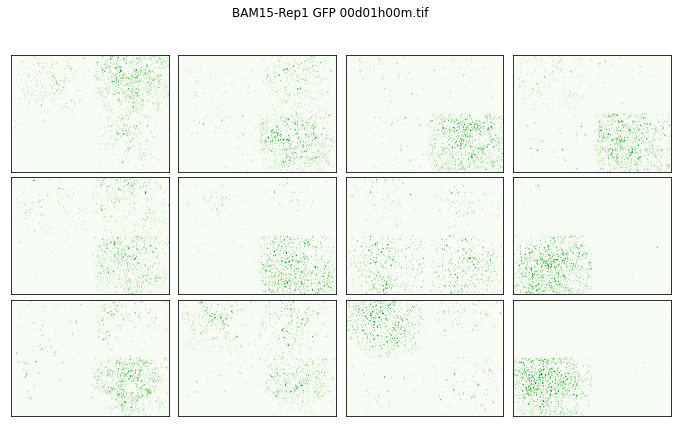

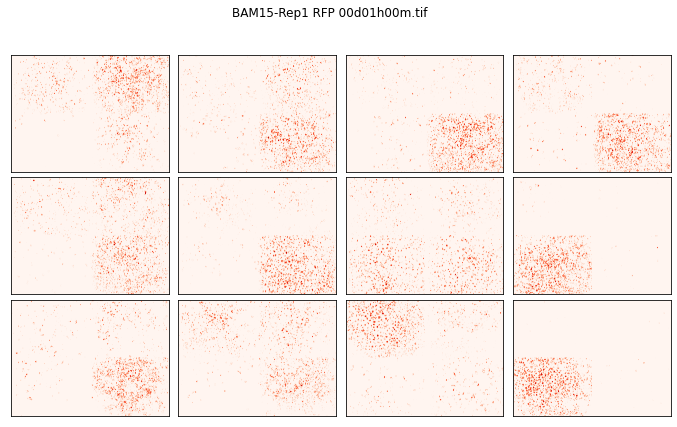

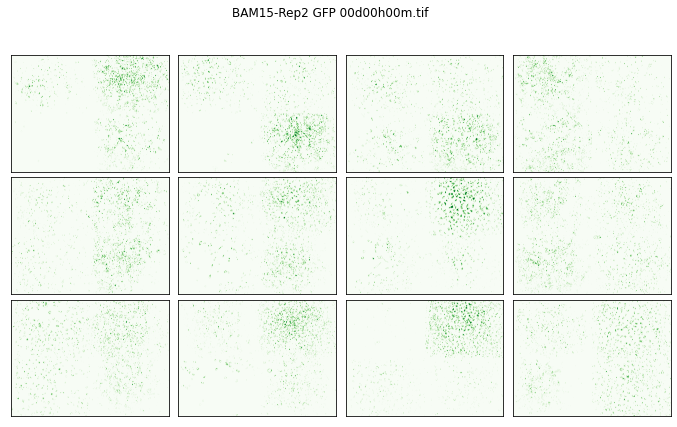

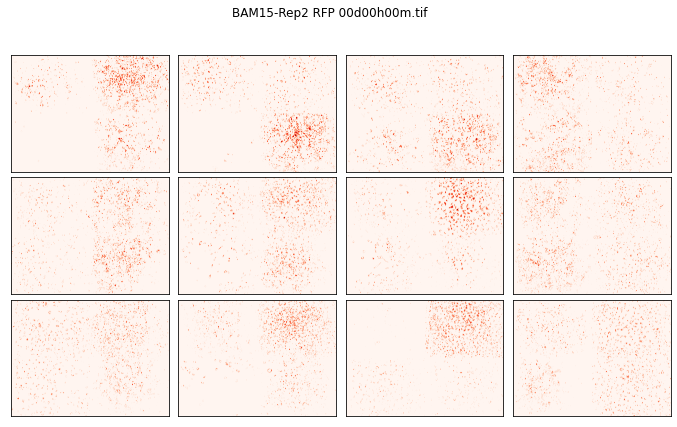

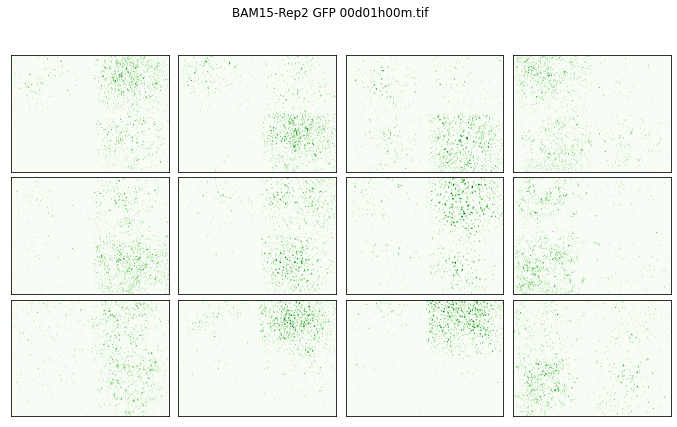

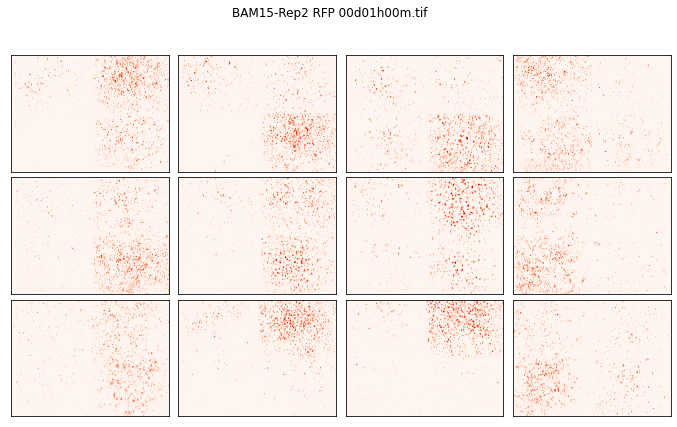

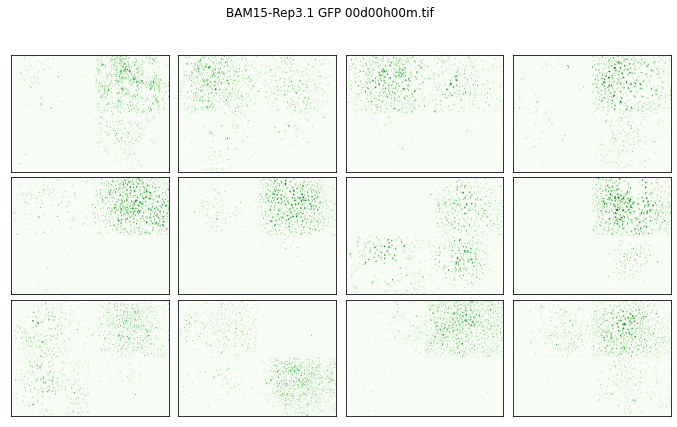

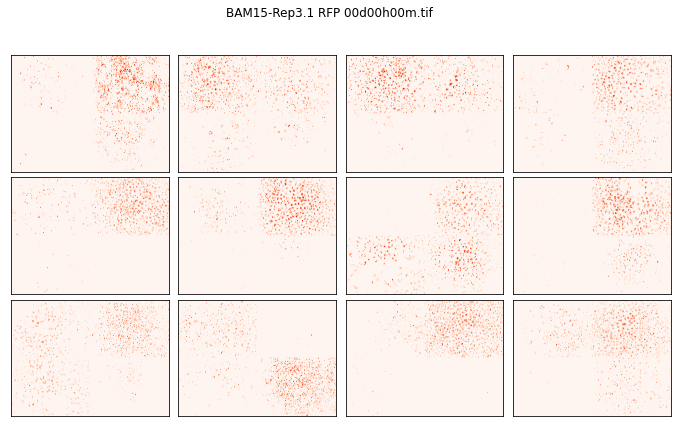

In [315]:
# Plot images after filters have been applied
# to verify correct settings:
fig_list = plot_all(image_dict, plate_dim)

In [316]:
TMRE_df

,Plate,Well,Time,TMRE_norm
0,BAM15-Rep1,A1,00d00h00m,0.060126
1,BAM15-Rep1,A1,00d01h00m,0.059782
2,BAM15-Rep1,A2,00d00h00m,0.059667
3,BAM15-Rep1,A2,00d01h00m,0.059984
4,BAM15-Rep1,A3,00d00h00m,0.056314
5,BAM15-Rep1,A3,00d01h00m,0.056924
6,BAM15-Rep1,A4,00d00h00m,0.059045
7,BAM15-Rep1,A4,00d01h00m,0.057196
8,BAM15-Rep1,B1,00d00h00m,0.070559
9,BAM15-Rep1,B1,00d01h00m,0.058429


In [317]:
TMRE_df[TMRE_df['Time'] == '00d00h00m']

,Plate,Well,Time,TMRE_norm
0,BAM15-Rep1,A1,00d00h00m,0.060126
2,BAM15-Rep1,A2,00d00h00m,0.059667
4,BAM15-Rep1,A3,00d00h00m,0.056314
6,BAM15-Rep1,A4,00d00h00m,0.059045
8,BAM15-Rep1,B1,00d00h00m,0.070559
10,BAM15-Rep1,B2,00d00h00m,0.071619
12,BAM15-Rep1,B3,00d00h00m,0.078520
14,BAM15-Rep1,B4,00d00h00m,0.073942
16,BAM15-Rep1,C1,00d00h00m,0.091993
18,BAM15-Rep1,C2,00d00h00m,0.091895


In [318]:
mask = (TMRE_df['Time'] == '00d00h00m')# & ((TMRE_df['Plate'] == 'BAM15-Rep1') | (TMRE_df['Plate'] == 'BAM15-Rep2'))

In [319]:
TMRE_avg = TMRE_df.loc[mask, ['Well', 'TMRE_norm']].groupby('Well').agg('mean')

In [332]:
conc = [2000/2**i for i in range(11)] + [0.2]
conc = np.array(conc)

#### !!!! Maybe last row is reversed???
#conc[8:12] = conc[8:12][::-1]


In [333]:
conc

array([2.000000e+03, 1.000000e+03, 5.000000e+02, 2.500000e+02,
       1.250000e+02, 6.250000e+01, 3.125000e+01, 1.562500e+01,
       7.812500e+00, 3.906250e+00, 1.953125e+00, 2.000000e-01])

In [334]:
TMRE_avg['BAM15'] = conc

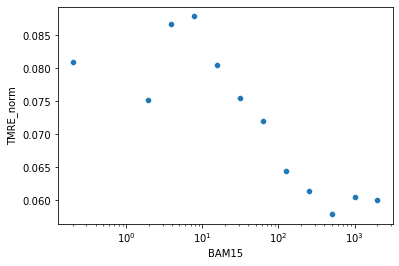

In [335]:
mask = TMRE_avg['BAM15'] != -1

g1 = sns.scatterplot(x='BAM15', y='TMRE_norm', data=TMRE_avg[mask])
g1.set_xscale('log')


In [231]:
mask = (TMRE_df['Time'] == '00d00h00m')# & ((TMRE_df['Plate'] == 'Anti-Rep1') | (TMRE_df['Plate'] == 'Anti-Rep2'))

In [232]:
TMRE_avg = TMRE_df.loc[mask, ['Well', 'TMRE_norm']].groupby('Well').agg('mean')

In [233]:
conc = [1000/2**i for i in range(11)] + [0.4]
conc = np.array(conc)
TMRE_avg['Anti'] = conc

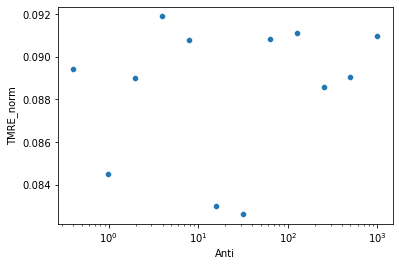

In [234]:
mask = TMRE_avg['Anti'] != -1

g1 = sns.scatterplot(x='Anti', y='TMRE_norm', data=TMRE_avg[mask])
g1.set_xscale('log')